#### importing necessaries libraries

In [31]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import davies_bouldin_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### loading and reading the data set

In [2]:
customers = pd.read_csv('Customers.csv')
transactions = pd.read_csv('Transactions.csv')
products = pd.read_csv('Products.csv')

### feature engineering

In [3]:
transactions = transactions.merge(customers[['CustomerID', 'Region']], on='CustomerID', how='left')
transactions = transactions.merge(products[['ProductID', 'Category']], on='ProductID', how='left')

### aggregate transaction data to create customer profiles

In [4]:
customer_profile = transactions.groupby('CustomerID').agg(
    total_value=('TotalValue', 'sum'),
    num_transactions=('TransactionID', 'nunique'),
    num_products=('ProductID', 'nunique'),
    avg_spending=('TotalValue', 'mean'),
    most_common_category=('Category', lambda x: x.mode()[0]),
).reset_index()

### adding demographic features like region and signup date

In [7]:
customers['SignupDate'] = pd.to_datetime(customers['SignupDate'])
customers['signup_year'] = customers['SignupDate'].dt.year
customers['signup_month'] = customers['SignupDate'].dt.month

### merging demographic features

In [8]:
customer_profile = customer_profile.merge(customers[['CustomerID', 'Region', 'signup_year', 'signup_month']], on='CustomerID', how='left')

In [10]:
scaler = StandardScaler()

In [12]:
numeric_features = ['total_value', 'num_transactions', 'num_products', 'avg_spending']
customer_profile[numeric_features] = scaler.fit_transform(customer_profile[numeric_features])

### one hot encoding categorical features like region

In [13]:
customer_profile = pd.get_dummies(customer_profile, columns=['Region'], drop_first=True)

### prepare features set for clustering

In [14]:
feature_columns = numeric_features + [col for col in customer_profile.columns if col.startswith('Region')]
X = customer_profile[feature_columns]

### apply k-means clustering

In [16]:
inertia = []
db_index = []

In [26]:
for n_clusters in range(2, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)
    db_index.append(davies_bouldin_score(X, kmeans.labels_))
best_n_clusters = np.argmin(db_index) + 2 # Adding 2 because we start from 2 clusters
print(f"Best number of clusters based on Davies-Bouldin Index: {best_n_clusters}")

Best number of clusters based on Davies-Bouldin Index: 2


C:\Users\sridh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sridh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sridh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\sridh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Window

### perform pca to reduce the dimensions of the data to 2D for visualization

In [27]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

### fit the k-means model with the best number of clusters

In [28]:
kmeans_best = KMeans(n_clusters=best_n_clusters, random_state=42)
customer_profile['Cluster'] = kmeans_best.fit_predict(X)

C:\Users\sridh\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1429: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [29]:
pca_df = pd.DataFrame(X_pca, columns=['PCA1', 'PCA2'])
pca_df['Cluster'] = customer_profile['Cluster']

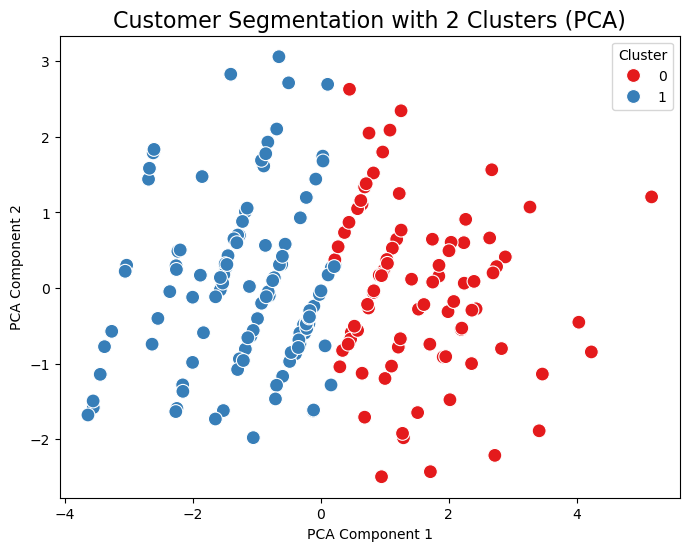

In [32]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=pca_df, x='PCA1', y='PCA2', hue='Cluster', palette='Set1', s=100, marker='o')
plt.title(f'Customer Segmentation with {best_n_clusters} Clusters (PCA)', fontsize=16)
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Cluster')
plt.show()

#### generating clustering metrics and save results
### davies bouldin index for the best number of clusters

In [33]:
best_db_index = db_index[best_n_clusters - 2]
print(f'Davies-Bouldin Index for {best_n_clusters} clusters: {best_db_index}')

Davies-Bouldin Index for 2 clusters: 1.1363881016757837


### add clustering results to customer profile

In [35]:
customer_profile['Cluster'] = customer_profile['Cluster']

In [36]:
customer_profile[['CustomerID', 'Cluster']].to_csv('Customer_Segmentation_Results.csv', index=False)

In [37]:
print(customer_profile[['CustomerID', 'Cluster']].head())

  CustomerID  Cluster
0      C0001        1
1      C0002        1
2      C0003        1
3      C0004        0
4      C0005        1
